In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import gc

from sklearn.model_selection import train_test_split
import optuna

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import gc

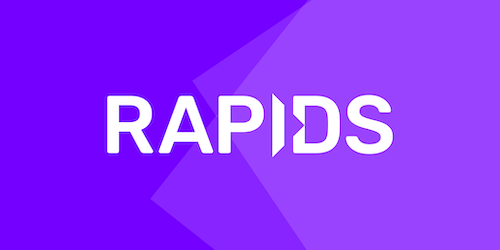

Rapids is a great option to scale data processing on GPUs. With a lot of machine learning modelling moving to GPUs, Rapids enables to build end-to-end data science solutions on one or more GPUs.

Documentation: https://docs.rapids.ai/

In [ ]:
# rapids installation (make sure to turn on GPU)
import sys
!cp ../input/rapids/rapids.0.16.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path

import cudf

In [ ]:
%%time
train_df = cudf.read_csv("../input/tabular-playground-series-oct-2021/train.csv")
test_df = cudf.read_csv("../input/tabular-playground-series-oct-2021/test.csv")
sample_df = cudf.read_csv("../input/tabular-playground-series-oct-2021/sample_submission.csv")

In [ ]:
train_df = train_df.to_pandas()
test_df = test_df.to_pandas()
sample_df = sample_df.to_pandas()

In [ ]:
print('Training Data Shape.....',train_df.shape)
print("Testing dat shape....",test_df.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
pie = ax.pie([len(train_df), len(test_df)],
             labels=["Train dataset", "Test dataset"],
             colors=["salmon", "teal"],
             textprops={"fontsize": 15},
             autopct='%1.1f%%')
ax.axis("equal")
ax.set_title("Dataset length comparison", fontsize=18)
fig.set_facecolor('white')
plt.show();

In [ ]:
train_df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7.5))
sns.countplot(x='target',data=train_df)
plt.title("Target values distribution", fontsize=20, pad=15)
plt.ylabel("Amount of values", fontsize=14, labelpad=15)
plt.xlabel("Target value", fontsize=14, labelpad=10)
plt.show()

In [ ]:
features = [x for x in train_df.columns if x[0]=="f"]

# df = pd.concat([train_df[features], test_df[features]], axis=0)
# df.reset_index(inplace=True, drop=True)

# unique_values = df[features].nunique() < 10
# cat_features = unique_values[unique_values==True].index
# unique_values = df[features].nunique() > 10
# num_features = unique_values[unique_values==True].index

# print(f"There are {len(cat_features)} categorical features: {cat_features}")
# print(f"There are {len(num_features)} continuous features: {num_features}")

In [ ]:
train_df.head()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import gc
import xgboost as xgb
import lightgbm as lgb

pd.set_option('display.max_columns', 200)

In [ ]:
!nvidia-smi

# XGBoost GPU

In [ ]:
MAX_TREE_DEPTH = 8
TREE_METHOD = 'gpu_hist'
ITERATIONS = 1000
SUBSAMPLE = 0.6
REGULARIZATION = 0.1
GAMMA = 0.3
POS_WEIGHT = 1
EARLY_STOP = 10

params = {'tree_method': TREE_METHOD, 'max_depth': MAX_TREE_DEPTH, 'alpha': REGULARIZATION,
          'gamma': GAMMA, 'subsample': SUBSAMPLE, 'scale_pos_weight': POS_WEIGHT, 'learning_rate': 0.05, 
          'silent': 1, 'objective':'binary:logistic', 'eval_metric': 'auc',
          'n_gpus': 1}

In [ ]:
%%time
nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

target = 'target'
predictors = train_df.columns.values.tolist()[1:-1]

i = 1
for train_index, valid_index in skf.split(train_df, train_df.target.values):
    print("\nFold {}".format(i))
    xg_train = xgb.DMatrix(train_df.iloc[train_index][predictors].values,
                           train_df.iloc[train_index][target].values,                           
                           )
    xg_valid = xgb.DMatrix(train_df.iloc[valid_index][predictors].values,
                           train_df.iloc[valid_index][target].values,                           
                           )   

    
    clf = xgb.train(params, xg_train, ITERATIONS, evals=[(xg_train, "train"), (xg_valid, "eval")],
                early_stopping_rounds=EARLY_STOP, verbose_eval=False)
    oof[valid_index] = clf.predict(xgb.DMatrix(train_df.iloc[valid_index][predictors].values)) 
    
    predictions += clf.predict(xgb.DMatrix(test_df[predictors].values)) / nfold
    i = i + 1

print("\n\nCV AUC: {:<0.2f}".format(metrics.roc_auc_score(train_df.target.values, oof)))


In [ ]:
sub_df = pd.DataFrame({"id": test_df.id.values})
sub_df["target"] = predictions
sub_df[:10]

In [ ]:
sub_df.to_csv("sub_xgb.csv",index=False)

In [ ]:
del sub_df

# LightGBM GPU

In [ ]:

param = {
        'num_leaves': 10,
        'max_bin': 127,
        'min_data_in_leaf': 11,
        'learning_rate': 0.02,
        'min_sum_hessian_in_leaf': 0.00245,
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': 0.05,
        'lambda_l1': 4.972,
        'lambda_l2': 2.276,
        'min_gain_to_split': 0.65,
        'max_depth': 14,
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

In [ ]:
%%time
nfold = 2


target = 'target'
predictors = train_df.columns.values.tolist()[1:-1]

skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

i = 1
for train_index, valid_index in skf.split(train_df, train_df.target.values):
    print("\nfold {}".format(i))
    xg_train = lgb.Dataset(train_df.iloc[train_index][predictors].values,
                           label=train_df.iloc[train_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(train_df.iloc[valid_index][predictors].values,
                           label=train_df.iloc[valid_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )   

    
    clf = lgb.train(param, xg_train, 5000, valid_sets = [xg_valid], verbose_eval=50, early_stopping_rounds = 50)
    oof[valid_index] = clf.predict(train_df.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    
    predictions += clf.predict(test_df[predictors], num_iteration=clf.best_iteration) / nfold
    i = i + 1

print("\n\nCV AUC: {:<0.2f}".format(metrics.roc_auc_score(train_df.target.values, oof)))


In [ ]:
sub_df = pd.DataFrame({"id": test_df.id.values})
sub_df["target"] = predictions
sub_df[:10]

In [ ]:
sub_df.to_csv("lgbm.csv",index=False)